#### The goal of this notebook is to validate the method of ignition energy testing with known experimental data.
#### This will be done using existing data on stoich GOX/GH2 ignition energy 

In [1]:
import cantera as ct
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt

In [2]:
# Unit conversions
psi2Pa = 6894.76

In [3]:
# setpoints of engine
OF = 2

#mass flow rates [kg/s]
mdot_total = 1 
mdot_lox = mdot_total * (OF/(OF+1))
mdot_kero = mdot_total * (1 / (OF + 1))

# Propellant Temps [K]
T_lox = 298 
T_kero = 298
T_amb = 298

T_mean = T_lox * (OF/(OF+1)) + T_kero * (1/(OF+1))

#pressures [Pa]
P_chamber = 500 * psi2Pa 
P_amb = 14.7 * psi2Pa

In [20]:
# H2 reaction mechanism

#mixed inlet
Y_mix = {"O2": (OF/(OF+1)), "H2": (1/(OF+1))}
inlet = ct.Solution("h2_sandiego.yaml")
inlet.TPY = T_mean, P_chamber, Y_mix

# arbitrary exhaust 
exhaust = ct.Solution("h2_sandiego.yaml")
exhaust.TP = T_amb, P_amb


Simulation Took 0.00s to compute, with 666 steps


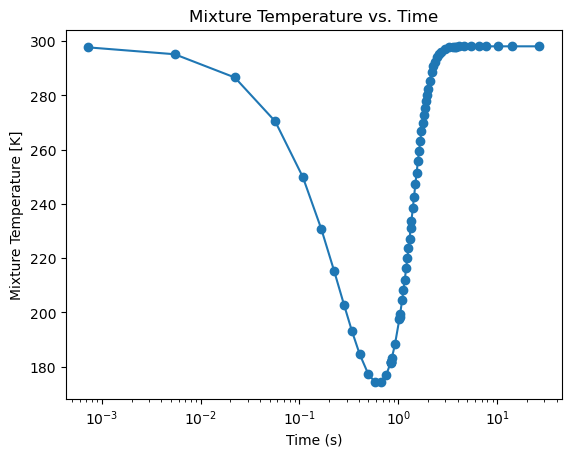

In [28]:
# lox & kero res --(mass flow controller)-> mixer -> chamber --(Pressure Reg)-> outlet 
enthalpy_inlet = inlet.h
N = 1000
enthalpy_steps = 1000
h_array = np.arange(enthalpy_inlet, enthalpy_inlet+N, enthalpy_steps)
for i in range(len(h_array)):
    # reservoirs (inlet and outlet)
    res_inlet = ct.Reservoir(inlet, name="Inlet", clone=True)
    res_outlet = ct.Reservoir(exhaust, name="Outlet", clone=True)

    # reactor 
    rctr_chamber = ct.IdealGasReactor(inlet, name="Chamber", clone=True,  energy='on')

    # mass flow controller (reservoir -> reactor)
    mfc_inlet = ct.MassFlowController(upstream= res_inlet, downstream= rctr_chamber, mdot=lambda t:mdot_total, name="Propellant Mass Flow Controller") #lox res to mixer

    #pressure controllers (outlet)
    pc_outlet = ct.PressureController(upstream=rctr_chamber, downstream=res_outlet, primary=mfc_inlet, K=1e-5)

    sim = ct.ReactorNet([rctr_chamber])
    # Create a SolutionArray to store the data
    time_history = ct.SolutionArray(exhaust, extra=["t"])

    # Set the maximum simulation time
    max_simulation_time = 50  # seconds

    # Start the stopwatch
    tic = time.time()

    # Set simulation start time to zero
    t = 0
    counter = 1
    while t < max_simulation_time:
        t = sim.step()

        # We will store only every 10th value.
        if counter % 10 == 0:
            # Extract the state of the reactor
            time_history.append(rctr_chamber.phase.state, t=t)

        counter += 1

    # Stop the stopwatch
    toc = time.time()

    print(f"Simulation Took {toc-tic:3.2f}s to compute, with {counter} steps")
    
    #plot results
    plt.figure()
    plt.semilogx(time_history.t, time_history.T, "-o")
    plt.xlabel("Time (s)")
    plt.ylabel("Mixture Temperature [K]")
    plt.title("Mixture Temperature vs. Time")
    plt.show()
    df = time_history.to_pandas()
    df